In [1]:
import pyscf
import pyscf.tools
import pyscf.cc
import pyscf.qmmm
from pyscf import lib
from pyscf import gto
from pyscf import df
from pyscf import scf
from pyscf import mcscf
from pyscf import grad
from pyscf.lib import logger
from pyscf.scf import RHF
import pyscf.lib
import numpy as np
import numpy
import matplotlib.pyplot as plt
angstrom=1.889725989

In [31]:
NN=pyscf.gto.M(atom='N 0 0 1.1; N 0 0 0', basis='sto3G', verbose=3)
mf=RHF(NN)
mf.scf()
e_NN=mf.scf()

converged SCF energy = -107.496500511798
converged SCF energy = -107.496500511798


In [3]:
# the operators in 2nd quantiation
print(mf.get_hcore()[0])  #monoelettronic NE + kin   
print(mf.get_veff()[0])  # bielettronic operator takes as input argument (mol, dm )
print(mf.make_rdm1()[0])  # density matrix

[-2.75627018e+01 -6.35285045e+00  0.00000000e+00  0.00000000e+00
  9.38535097e-02 -3.00178430e-04 -1.39169276e+00  0.00000000e+00
  0.00000000e+00 -2.31837148e+00]
[ 1.20533259e+01  2.41964519e+00 -2.80291933e-18  4.94352361e-17
 -6.11342362e-02 -4.79474449e-04  5.24307596e-01  1.96444952e-18
  1.63468257e-17  8.81504407e-01]
[ 2.10647611e+00 -4.26665347e-01  3.15143677e-17 -6.56116587e-17
 -1.06156169e-01  1.33150500e-02  6.20895753e-03 -1.93202164e-17
 -1.85097710e-16 -1.01810643e-01]


In [4]:
#get the partial energy
print(mf.energy_elec())
print(mf.energy_nuc(),'equally',NN.energy_nuc())
print(mf.energy_tot())
print(mf.energy_elec()[0]+mf.energy_nuc())

(-131.0689399073251, 61.3140808568419)
23.572439395527272 equally 23.572439395527272
-107.49650051179783
-107.49650051179783


In [5]:
dm=mf.make_rdm1()
h1=mf.get_hcore()
h2=mf.get_veff()
S=mf.get_ovlp()

In [6]:
# examples of contraction
print ('monoelettronic enegy = ',np.einsum('ij,ji',h1,dm))
print ('Bielettronic enegy = ',np.einsum('ij,ji',h2,dm)/2)
print ('the sum of those two equals = ',mf.energy_elec()[0])
print('Total number of electrons= ',np.einsum('ij,ji',S,dm))

monoelettronic enegy =  -192.38302076416701
Bielettronic enegy =  61.3140808568419
the sum of those two equals =  -131.0689399073251
Total number of electrons=  14.0


In [7]:
"""
| mf.get_init_guess
            | mf.get_hcore
            | mf.get_ovlp
            | mf.get_veff
            | mf.get_fock
            | mf.get_grad
            | mf.eig
            | mf.get_occ
            | mf.make_rdm1
            | mf.energy_tot
            | mf.dump_chk
"""


'\n| mf.get_init_guess\n            | mf.get_hcore\n            | mf.get_ovlp\n            | mf.get_veff\n            | mf.get_fock\n            | mf.get_grad\n            | mf.eig\n            | mf.get_occ\n            | mf.make_rdm1\n            | mf.energy_tot\n            | mf.dump_chk\n'

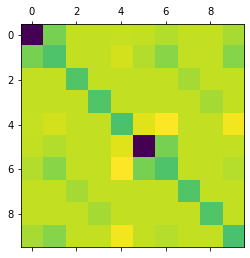

In [8]:
plt.matshow(NN.intor_symmetric('int1e_nuc'))

In [9]:
print(NN._atm)
mf.scf()

[[ 7 20  1 23  0  0]
 [ 7 24  1 27  0  0]]
converged SCF energy = -107.496500511798


-107.49650051179789

In [10]:
print(NN.nao)
print(NN._bas)
print(NN._env)
from pyscf import lib

10
[[ 0  0  3  1  0 28 31  0]
 [ 0  0  3  1  0 34 37  0]
 [ 0  1  3  1  0 40 43  0]
 [ 1  0  3  1  0 28 31  0]
 [ 1  0  3  1  0 34 37  0]
 [ 1  1  3  1  0 40 43  0]]
[137.03599968   0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           2.07869874   0.           0.
   0.           0.           0.          99.106169    18.052312
   4.8856602   12.24723354  11.84499063   3.69156624   3.7804559
   0.8784966    0.2857144   -0.68474806   0.91590581   0.69124784
   3.7804559    0.8784966    0.2857144    2.39776185   1.50777694
   0.23885724]


In [11]:
#copy and paste of the qmm_charge method to obtain the delta V operator on the AO basis 

print(NN.unit)
print(NN.cart)
intor = 'int3c2e_sph'
cintopt = gto.moleintor.make_cintopt(NN._atm, NN._bas,NN._env, intor)
coords,charges=NN.atom_coords(), np.asarray([-1,1])
dv = 0
blksize = int(min(mf.max_memory*1e6/8/NN.nao**2, 200))
print(blksize)
for i0, i1 in lib.prange(0, charges.size, blksize):
    fakemol = gto.fakemol_for_charges(coords[i0:i1])
    j3c = df.incore.aux_e2(NN, fakemol, intor=intor, aosym='s2ij', cintopt=cintopt)
    dv += numpy.einsum('xk,k->x', j3c, -charges[i0:i1])

angstrom
False
200


In [12]:
dv = lib.unpack_tril(dv)
dv.shape

(10, 10)

In [13]:
np.einsum('ij,ji',dv,dm) # the first alchemical derivative is null

1.1102230246251565e-16

In [22]:
CO=pyscf.gto.M(atom='C 0 0 0;O 0 0 1.1',basis='sto3G')
mfc=RHF(CO)
e_CO=mfc.kernel()

converged SCF energy = -111.219048454705


In [15]:
dmc=mfc.make_rdm1()


In [16]:
def first_a_der(mol,charges=np.asarray([1,-1])):
    intor = 'int3c2e_sph'
    cintopt = gto.moleintor.make_cintopt(mol._atm, mol._bas, mol._env, intor)
    coords=mol.atom_coords()
    dV = 0
    blksize = int(min(mf.max_memory*1e6/8/mol.nao**2, 200))
    for i0, i1 in lib.prange(0, charges.size, blksize):
        fakemol = gto.fakemol_for_charges(coords[i0:i1])
        j3c = df.incore.aux_e2(mol, fakemol, intor=intor, aosym='s2ij', cintopt=cintopt)
        dV += numpy.einsum('xk,k->x', j3c, -charges[i0:i1])
    dV = lib.unpack_tril(dV)
    return dV


In [17]:
dV_CO=first_a_der(CO)

In [18]:
np.einsum('ij,ji',first_a_der(CO),dmc)

6.340187073203822

In [19]:
def dens_dh(mol,dh):
    deltaZ = np.array((dh,-dh))
    mf = pyscf.qmmm.mm_charge(pyscf.scf.RHF(mol), mol.atom_coords()/1.889725989, deltaZ)
    class NoSelfQMMM(mf.__class__):
        def energy_nuc(self):
            e_nuc=self.mol.energy_nuc()
            e_nuc-=dh**2/np.linalg.norm(self.mol.atom_coords()[0]-self.mol.atom_coords()[1])
            return e_nuc
    mf = NoSelfQMMM()
    en=mf.scf()
    return mf.make_rdm1(),en

In [21]:
dms=[dens_dh(CO,dh)[0] for dh in [-.2,-.1,0,.1,.2]]

converged SCF energy = -112.545650949194
converged SCF energy = -111.867785597183
converged SCF energy = -111.219048454705
converged SCF energy = -110.599886208879
converged SCF energy = -110.010681190845


In [24]:
e_NN_at_CO=dens_dh(CO,1)[1]
print ('the alchemical shift brings to dE =  ',e_NN_at_CO-e_CO)

converged SCF energy = -106.405205737936
the alchemical shift brings to dE =   4.8138427167694715


In [53]:
dVNN=-1/(1.1*angstrom)
dE1=np.einsum('ij,ji',dms[2],dV_CO)
print ('first order alchemy correction = ', dVNN+dE1)
dRho1=(dms[3]-dms[1])/2/.1
dE2=np.einsum('ij,ji',dRho1,dV_CO)/2
print ('second order alchemy correction = ', dVNN+dE1+dE2)
dRho2=(dms[3]-2*dms[2]+dms[1])/.01
dE3=np.einsum('ij,ji',dRho2,dV_CO)/6
print ('third order alchemy correction = ', dVNN+dE1+dE2+dE3)
dRho3=(dms[4]*0.5-dms[3]+dms[1]-dms[0]*0.5)/.001
dE4=np.einsum('ij,ji',dRho3,dV_CO)/24
print ('fourth order alchemy correction = ', dVNN+dE1+dE2+dE3+dE4)
dRho4=(dms[4]-4*dms[3]+6*dms[2]-4*dms[1]+dms[0])/.0001
dE5=np.einsum('ij,ji',dRho4,dV_CO)/120
print ('fifth order alchemy correction = ', dVNN+dE1+dE2+dE3+dE4+dE5)
print ('Error due to alchemy = ', e_NN_at_CO-e_CO-(dVNN+dE1+dE2+dE3+dE4+dE5) )
print ('Error due to basis set (sto3g) = ', e_NN_at_CO-e_NN )

print(dE1,dE2,dE3,dE4,dE5)

first order alchemy correction =  5.8591168469473685
second order alchemy correction =  4.861713665575798
third order alchemy correction =  4.792730883417541
fourth order alchemy correction =  4.819434471867753
fifth order alchemy correction =  4.816123995534059
Error due to alchemy =  -0.002281278764587391
Error due to basis set (sto3g) =  1.0912947738620602
6.34018707320381 -0.9974031813715704 -0.06898278215825714 0.02670358845021252 -0.0033104763336944936


3 mHa of error + error due to basis set,
In order to get a better precision the coefficient of the finite difference scheme can follow the table: https://en.wikipedia.org/wiki/Finite_difference_coefficient , in which expecially the fist and the second dervtive can b taken exact up to $dh^4$

In [43]:
# for a five point scheme 
coeff5p=np.asarray([[1/12,-2/3,0,2/3,-1/12],[-1/12,4/3,-5/2,4/3,-1/12],[-1/2,1,0,-1,1/2],[1,-4,6,-4,1]])
dms_array=np.asarray(dms)

In [57]:
dVNN=-1/(1.1*angstrom)
dE1=np.einsum('ij,ji',dms[2],dV_CO)
print ('first order alchemy correction = ', dVNN+dE1)
print ('Error due to alchemy = ', e_NN_at_CO-e_CO-(dVNN+dE1) )
dRho1=0
for i in range(5):
    dRho1+=dms_array[i]*coeff5p[0][i]
dRho1/=.1
dE2=np.einsum('ij,ji',dRho1,dV_CO)/2
print ('second order alchemy correction = ', dVNN+dE1+dE2)
print ('Error due to alchemy = ', e_NN_at_CO-e_CO-(dVNN+dE1+dE2) )
dRho2=0
for i in range(5):
    dRho2+=dms_array[i]*coeff5p[1][i]
dRho2/=.01
dE3=np.einsum('ij,ji',dRho2,dV_CO)/6
print ('third order alchemy correction = ', dVNN+dE1+dE2+dE3)
print ('Error due to alchemy = ', e_NN_at_CO-e_CO-(dVNN+dE1+dE2+dE3) )
dRho3=(dms[4]*0.5-dms[3]+dms[1]-dms[0]*0.5)/.001
dE4=np.einsum('ij,ji',dRho3,dV_CO)/24
print ('fourth order alchemy correction = ', dVNN+dE1+dE2+dE3+dE4)
print ('Error due to alchemy = ', e_NN_at_CO-e_CO-(dVNN+dE1+dE2+dE3+dE4) )
dRho4=(dms[4]-4*dms[3]+6*dms[2]-4*dms[1]+dms[0])/.0001
dE5=np.einsum('ij,ji',dRho4,dV_CO)/120
print ('fifth order alchemy correction = ', dVNN+dE1+dE2+dE3+dE4+dE5)
print ('Error due to alchemy = ', e_NN_at_CO-e_CO-(dVNN+dE1+dE2+dE3+dE4+dE5) )
print ('Error due to basis set (sto3g) = ', e_NN_at_CO-e_NN )
print(dVNN,dE1,dE2,dE3,dE4,dE5) 
#notice that now the error in alchemy is the same order of magnitude of dE5 

first order alchemy correction =  5.8591168469473685
Error due to alchemy =  -1.045274130177897
second order alchemy correction =  4.861179593806798
Error due to alchemy =  -0.04733687703732681
third order alchemy correction =  4.7922519862540405
Error due to alchemy =  0.021590730515431034
fourth order alchemy correction =  4.818955574704253
Error due to alchemy =  -0.005112857934781445
fifth order alchemy correction =  4.815645098370559
Error due to alchemy =  -0.001802381601087255
Error due to basis set (sto3g) =  1.0912947738620602
-0.48107022625644225 6.34018707320381 -0.9979372531405704 -0.0689276075527582 0.02670358845021252 -0.0033104763336944936


In [58]:
#for further processes

NN=pyscf.gto.M(atom='N 0 0 1.1; N 0 0 0', basis='sto3G', verbose=3)
mf2=RHF(NN)
print(mf2.get_hcore()[0])  #monoelettronic NE + kin   
print(mf2.get_veff()[0])  # bielettronic operator takes as input argument (mol, dm )
print(mf2.make_rdm1()[0])  # density matrix

[-2.75627018e+01 -6.35285045e+00  0.00000000e+00  0.00000000e+00
  9.38535097e-02 -3.00178430e-04 -1.39169276e+00  0.00000000e+00
  0.00000000e+00 -2.31837148e+00]


TypeError: '>' not supported between instances of 'NoneType' and 'int'